# Visualization


### Importing Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import torch
import os

from sklearn.model_selection import train_test_split


from skimage.io import imread
from os import listdir


### Exploring Data Structures

In [2]:
base_dir = os.getcwd()

In [3]:
data_dir = os.path.join(base_dir, 'data')
output_dir = os.path.join(base_dir, 'outputs')
processed_data_dir = os.path.join(base_dir, 'processed_data')
files = listdir(data_dir)

print(len(files))

280


In [4]:
len(data_dir)

63

In [5]:
train_file_path = os.path.join(processed_data_dir, 'train_df.pkl')
test_file_path =  os.path.join(processed_data_dir, 'test_df.pkl')
dev_file_path =  os.path.join(processed_data_dir, 'dev_df.pkl')

In [6]:
files[0:10]

['10253',
 '10254',
 '10255',
 '10256',
 '10257',
 '10258',
 '10259',
 '10260',
 '10261',
 '10262']

In [7]:
patients_dir =os.path.join(data_dir, 'IDC_regular_ps50_idx5')

folder = os.listdir(patients_dir)

print("Number of patients: " , len(folder))

Number of patients:  279


In [8]:
total_images = sum([len(os.listdir(os.path.join(patients_dir, f, str(c)))) for f in folder for c in [0, 1]])

In [9]:
print("Total patches", total_images)

Total patches 277524


### Storing Data

In [10]:
data = pd.DataFrame(index=np.arange(0, total_images), columns=["patient_id", "path", "target"])

k = 0
for n in range(len(folder)):
    patient_id = folder[n]
    patient_path = os.path.join(data_dir, patient_id)
    for c in [0, 1]:
        class_path = os.path.join(patient_path, str(c))
        subfiles = os.listdir(class_path)
        for m in range(len(subfiles)):
            image_path = subfiles[m]
            data.iloc[k]["path"] = os.path.join(class_path, image_path)
            data.iloc[k]["target"] = c
            data.iloc[k]["patient_id"] = patient_id
            k += 1

In [11]:
data.shape

(277524, 3)

## Data Visualization

In [12]:
data.target

0         0
1         0
2         0
3         0
4         0
         ..
277519    1
277520    1
277521    1
277522    1
277523    1
Name: target, Length: 277524, dtype: object

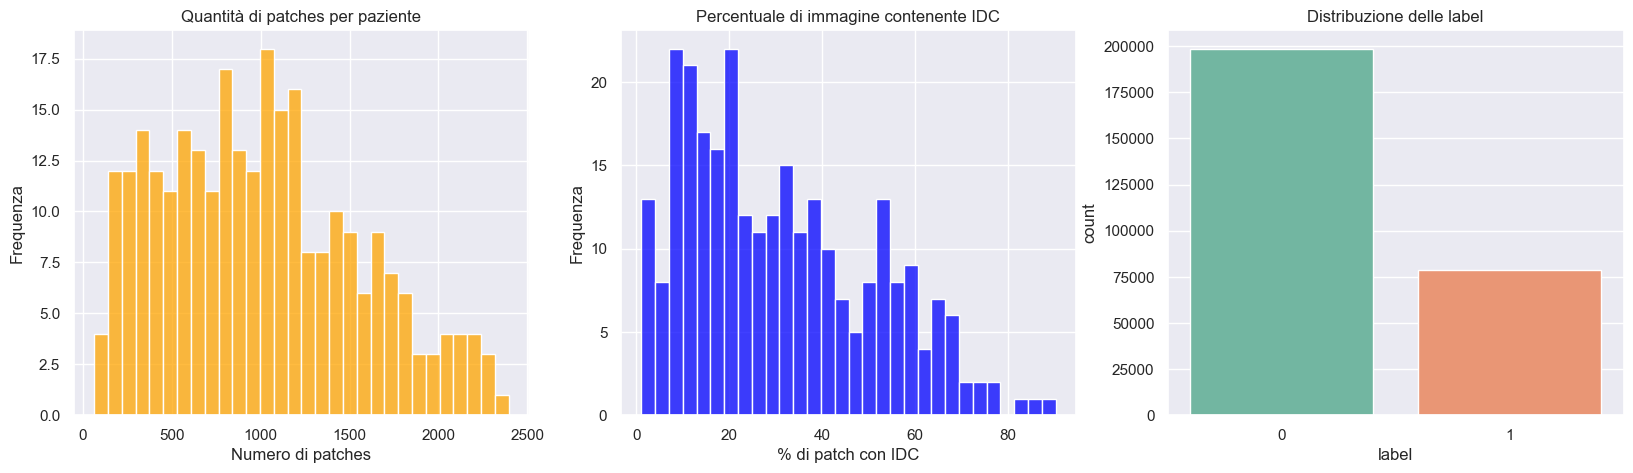

In [13]:
cancer_perc = data.groupby("patient_id").target.value_counts()/ data.groupby("patient_id").target.size()
cancer_perc = cancer_perc.unstack()

fig, ax = plt.subplots(1,3,figsize=(20,5))

sns.histplot(data.groupby("patient_id").size(), ax=ax[0], color="Orange", kde=False, bins=30)
ax[0].set_xlabel("Numero di patches")
ax[0].set_ylabel("Frequenza");
ax[0].set_title("Quantità di patches per paziente");

sns.histplot(cancer_perc.loc[:, 1]*100, ax=ax[1], color="Blue", kde=False, bins=30)
ax[1].set_title("Percentuale di immagine contenente IDC")
ax[1].set_ylabel("Frequenza")
ax[1].set_xlabel("% di patch con IDC");

sns.countplot(data, x = "target", palette="Set2", ax=ax[2]);
ax[2].set_xlabel("label")
ax[2].set_title("Distribuzione delle label");
 
title = 'Data Distribution'
fig.savefig(os.path.join(output_dir, title+'.png'))
plt.show()

In [14]:
data.target = data.target.astype(int)

In [15]:
pos_selection = np.random.choice(data[data.target==1].index.values, size=50, replace=False)
neg_selection = np.random.choice(data[data.target==0].index.values, size=50, replace=False)

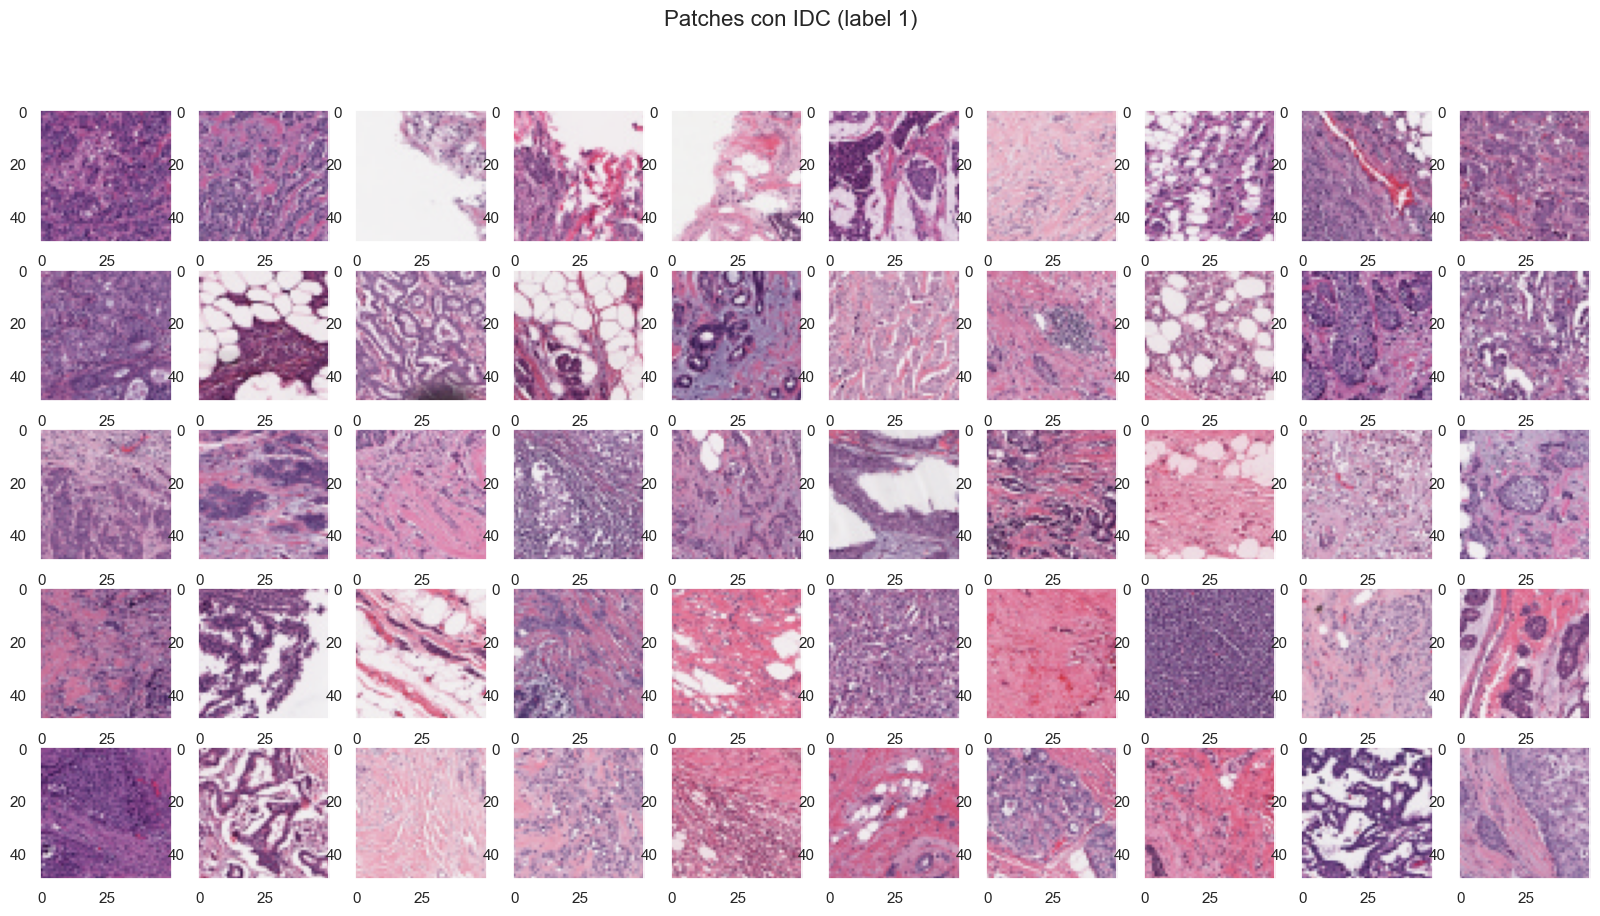

In [16]:
fig, ax = plt.subplots(5,10,figsize=(20,10))

for n in range(5):
    for m in range(10):
        idx = pos_selection[m + 10*n]
        image = imread(data.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

title = 'Patches con IDC (label 1)'
fig.suptitle(title, fontsize=16)
fig.savefig(os.path.join(output_dir, title+'.png'))
plt.show()

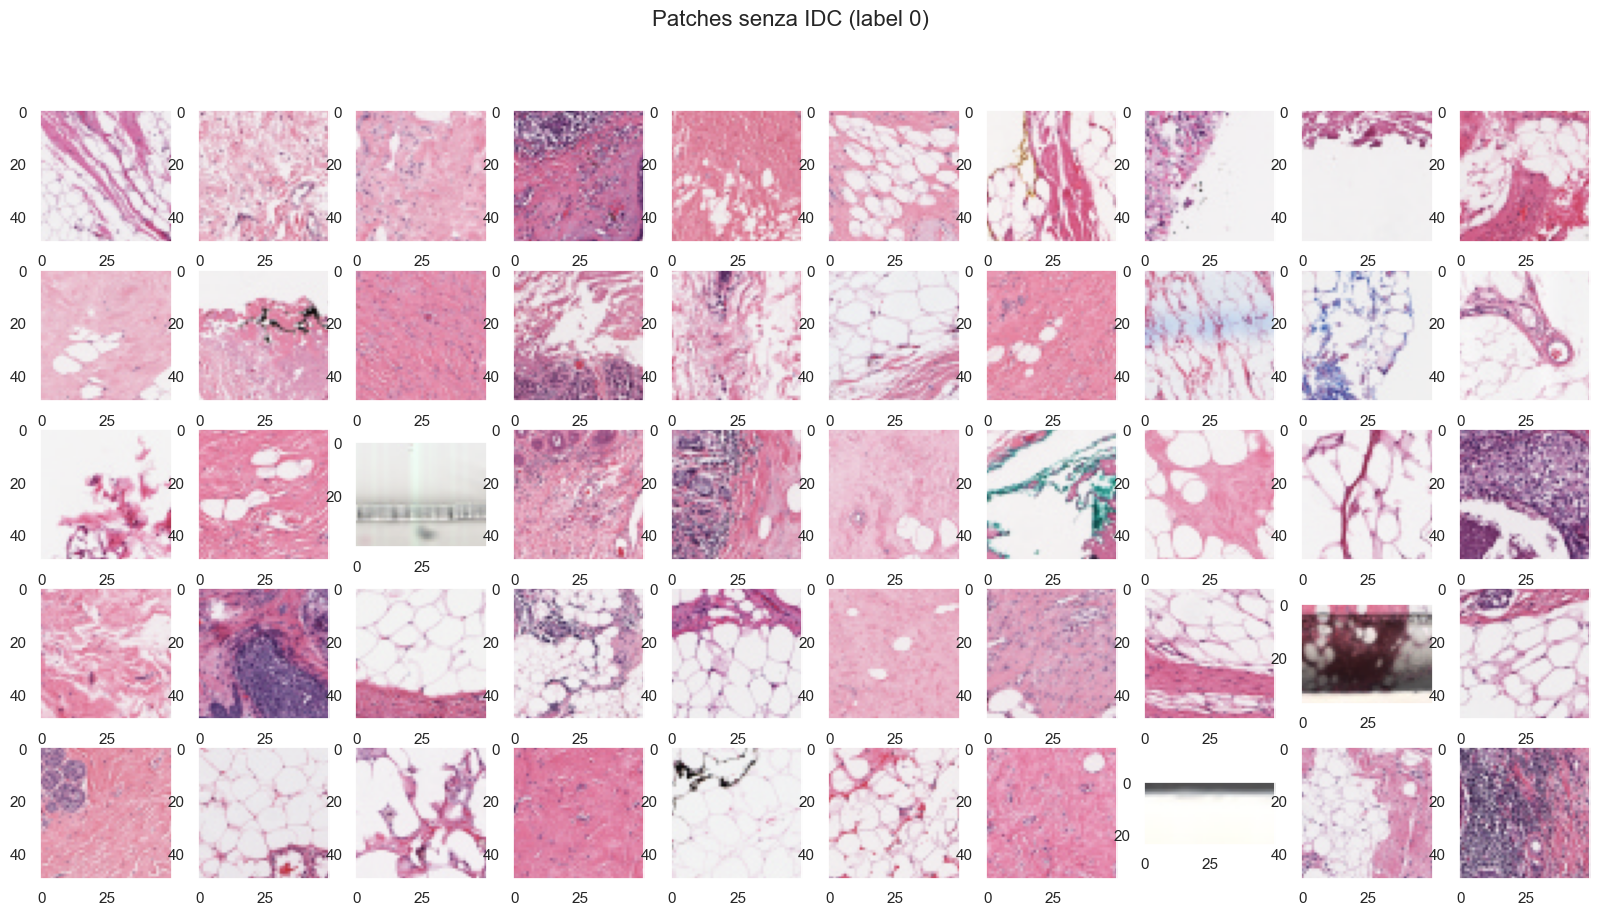

In [17]:
fig, ax = plt.subplots(5,10,figsize=(20,10))

for n in range(5):
    for m in range(10):
        idx = neg_selection[m + 10*n]
        image = imread(data.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

    
title = 'Patches senza IDC (label 0)'
fig.suptitle(title, fontsize=16)
fig.savefig(os.path.join(output_dir, title+'.png'))
plt.show()

In [18]:
def extract_coords(df):
    coord = df.path.str.rsplit("_", n=4, expand=True)
    coord = coord.drop([0, 1, 4], axis=1)
    coord = coord.rename({2: "x", 3: "y"}, axis=1)
    coord.loc[:, "x"] = coord.loc[:,"x"].str.replace("x", "", case=False).astype(int)
    coord.loc[:, "y"] = coord.loc[:,"y"].str.replace("y", "", case=False).astype(int)
    df.loc[:, "x"] = coord.x.values
    df.loc[:, "y"] = coord.y.values
    return df

def get_cancer_dataframe(patient_id, cancer_id):
    path = os.path.join(data_dir, patient_id, cancer_id)
    files = os.listdir(path)
    dataframe = pd.DataFrame(files, columns=["filename"])
    path_names = [os.path.join(path, filename) for filename in dataframe["filename"].values]
    dataframe = dataframe.filename.str.rsplit("_", n=4, expand=True)
    dataframe.loc[:, "target"] = int(cancer_id)
    dataframe.loc[:, "path"] = path_names
    dataframe = dataframe.drop([0, 1, 4], axis=1)
    dataframe = dataframe.rename({2: "x", 3: "y"}, axis=1)
    dataframe.loc[:, "x"] = dataframe.loc[:,"x"].str.replace("x", "", case=False).astype(int)
    dataframe.loc[:, "y"] = dataframe.loc[:,"y"].str.replace("y", "", case=False).astype(int)
    return dataframe

def get_patient_dataframe(patient_id):
    # Replace this with your actual base path
    df_0 = get_cancer_dataframe(patient_id, "0")
    df_1 = get_cancer_dataframe(patient_id, "1")
    patient_df = pd.concat([df_0, df_1], ignore_index=True)
    return patient_df

In [19]:
example = get_patient_dataframe(data.patient_id.values[0])
example.head(32)

x     y  target                                               path
0   1001  1001       0  c:\Users\noemi\OneDrive\Documenti\GitHub\CNN-v...
1   1001  1051       0  c:\Users\noemi\OneDrive\Documenti\GitHub\CNN-v...
2   1001  1101       0  c:\Users\noemi\OneDrive\Documenti\GitHub\CNN-v...
3   1001  1151       0  c:\Users\noemi\OneDrive\Documenti\GitHub\CNN-v...
4   1001  1201       0  c:\Users\noemi\OneDrive\Documenti\GitHub\CNN-v...
5   1001  1251       0  c:\Users\noemi\OneDrive\Documenti\GitHub\CNN-v...
6   1001  1301       0  c:\Users\noemi\OneDrive\Documenti\GitHub\CNN-v...
7   1001  1351       0  c:\Users\noemi\OneDrive\Documenti\GitHub\CNN-v...
8   1001  1501       0  c:\Users\noemi\OneDrive\Documenti\GitHub\CNN-v...
9   1001  1551       0  c:\Users\noemi\OneDrive\Documenti\GitHub\CNN-v...
10  1001  1701       0  c:\Users\noemi\OneDrive\Documenti\GitHub\CNN-v...
11  1001   351       0  c:\Users\noemi\OneDrive\Documenti\GitHub\CNN-v...
12  1001   401       0  c:\Users\noemi\OneDrive\Documenti\GitHub\CNN-v...
13  1001   451       0  c:\Users\noemi\OneDrive\Documenti\GitHub\CNN-v...
14  1001   501       0  c:\Users\noemi\OneDrive\Documenti\GitHub\CNN-v...
15  1001   551       0  c:\Users\noemi\OneDrive\Documenti\GitHub\CNN-v...
16  1001   601       0  c:\Users\noemi\OneDrive\Documenti\GitHub\CNN-v...
17  1001   651       0  c:\Users\noemi\OneDrive\Documenti\GitHub\CNN-v...
18  1001   701       0  c:\Users\noemi\OneDrive\Documenti\GitHub\CNN-v...
19  1001   751       0  c:\Users\noemi\OneDrive\Documenti\GitHub\CNN-v...
20  1001   801       0  c:\Users\noemi\OneDrive\Documenti\GitHub\CNN-v...
21  1001   951       0  c:\Users\noemi\OneDrive\Documenti\GitHub\CNN-v...
22  1051  1001       0  c:\Users\noemi\OneDrive\Documenti\GitHub\CNN-v...
23  1051  1051       0  c:\Users\noemi\OneDrive\Documenti\GitHub\CNN-v...
24  1051  1101       0  c:\Users\noemi\OneDrive\Documenti\GitHub\CNN-v...
25  1051  1151       0  c:\Users\noemi\OneDrive\Documenti\GitHub\CNN-v...
26  1051  1201       0  c:\Users\noemi\OneDrive\Documenti\GitHub\CNN-v...
27  1051  1251       0  c:\Users\noemi\OneDrive\Documenti\GitHub\CNN-v...
28  1051  1301       0  c:\Users\noemi\OneDrive\Documenti\GitHub\CNN-v...
29  1051  1501       0  c:\Users\noemi\OneDrive\Documenti\GitHub\CNN-v...
30  1051   151       0  c:\Users\noemi\OneDrive\Documenti\GitHub\CNN-v...
31  1051  1601       0  c:\Users\noemi\OneDrive\Documenti\GitHub\CNN-v...

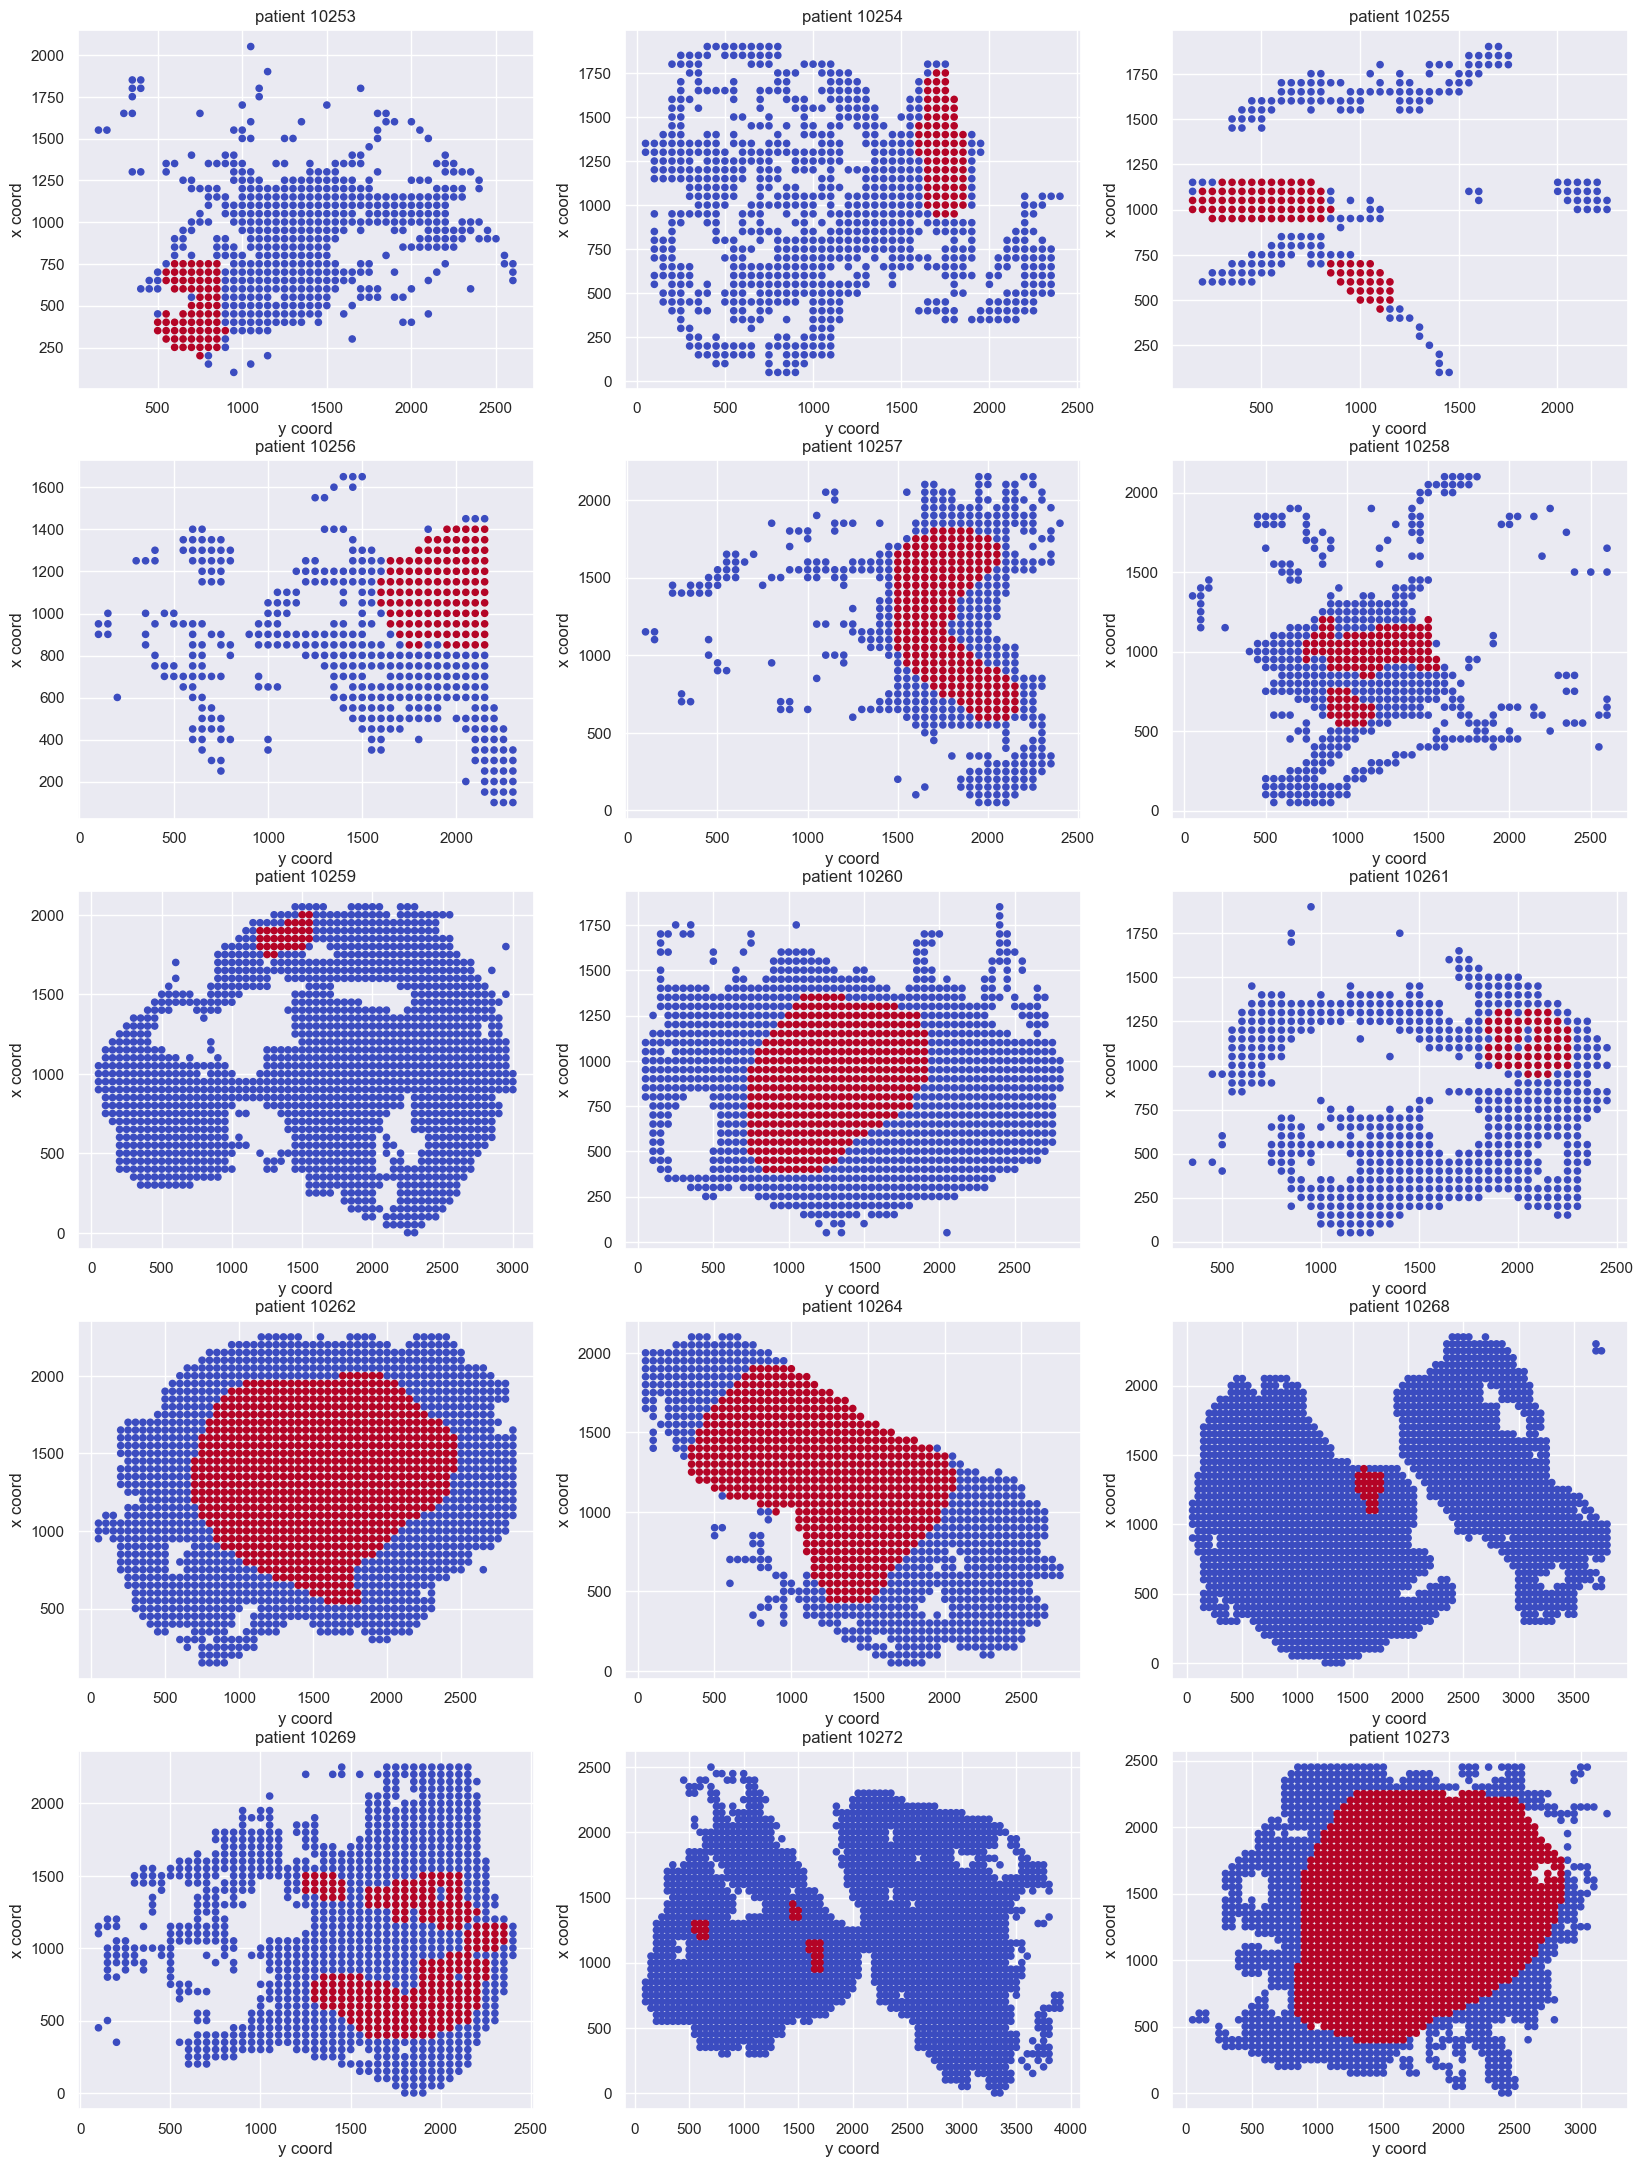

In [20]:
fig, ax = plt.subplots(5,3,figsize=(20, 27))

patient_ids = data.patient_id.unique()

for n in range(5):
    for m in range(3):
        patient_id = patient_ids[m + 3*n]
        example_df = get_patient_dataframe(patient_id)
        
        ax[n,m].scatter(example_df.x.values, example_df.y.values, c=example_df.target.values, cmap="coolwarm", s=20);
        ax[n,m].set_title("patient " + patient_id)
        ax[n,m].set_xlabel("y coord")
        ax[n,m].set_ylabel("x coord")

title = 'Distribuzione label nella scan intera'
fig.savefig(os.path.join(output_dir, title+'.png'))
plt.show()

In [21]:
def visualise_breast_tissue(patient_id, pred_df=None):
    example_df = get_patient_dataframe(patient_id)
    max_point = [example_df.y.max()-1, example_df.x.max()-1]
    grid = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    mask = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    if pred_df is not None:
        patient_df = pred_df[pred_df.patient_id == patient_id].copy()
    mask_proba = np.zeros(shape = (max_point[0] + 50, max_point[1] + 50, 1)).astype(float)
    
    broken_patches = []
    for n in range(len(example_df)):
        try:
            image = imread(example_df.path.values[n])
            
            target = example_df.target.values[n]
            
            x_coord = int(example_df.x.values[n])
            y_coord = int(example_df.y.values[n])
            x_start = x_coord - 1
            y_start = y_coord - 1
            x_end = x_start + 50
            y_end = y_start + 50

            grid[y_start:y_end, x_start:x_end] = image
            if target == 1:
                mask[y_start:y_end, x_start:x_end, 0] = 250
                mask[y_start:y_end, x_start:x_end, 1] = 0
                mask[y_start:y_end, x_start:x_end, 2] = 0
            if pred_df is not None:
                
                proba = patient_df[
                    (patient_df.x==x_coord) & (patient_df.y==y_coord)].proba
                mask_proba[y_start:y_end, x_start:x_end, 0] = float(proba)

        except ValueError:
            broken_patches.append(example_df.path.values[n])
    
    
    return grid, mask, broken_patches, mask_proba

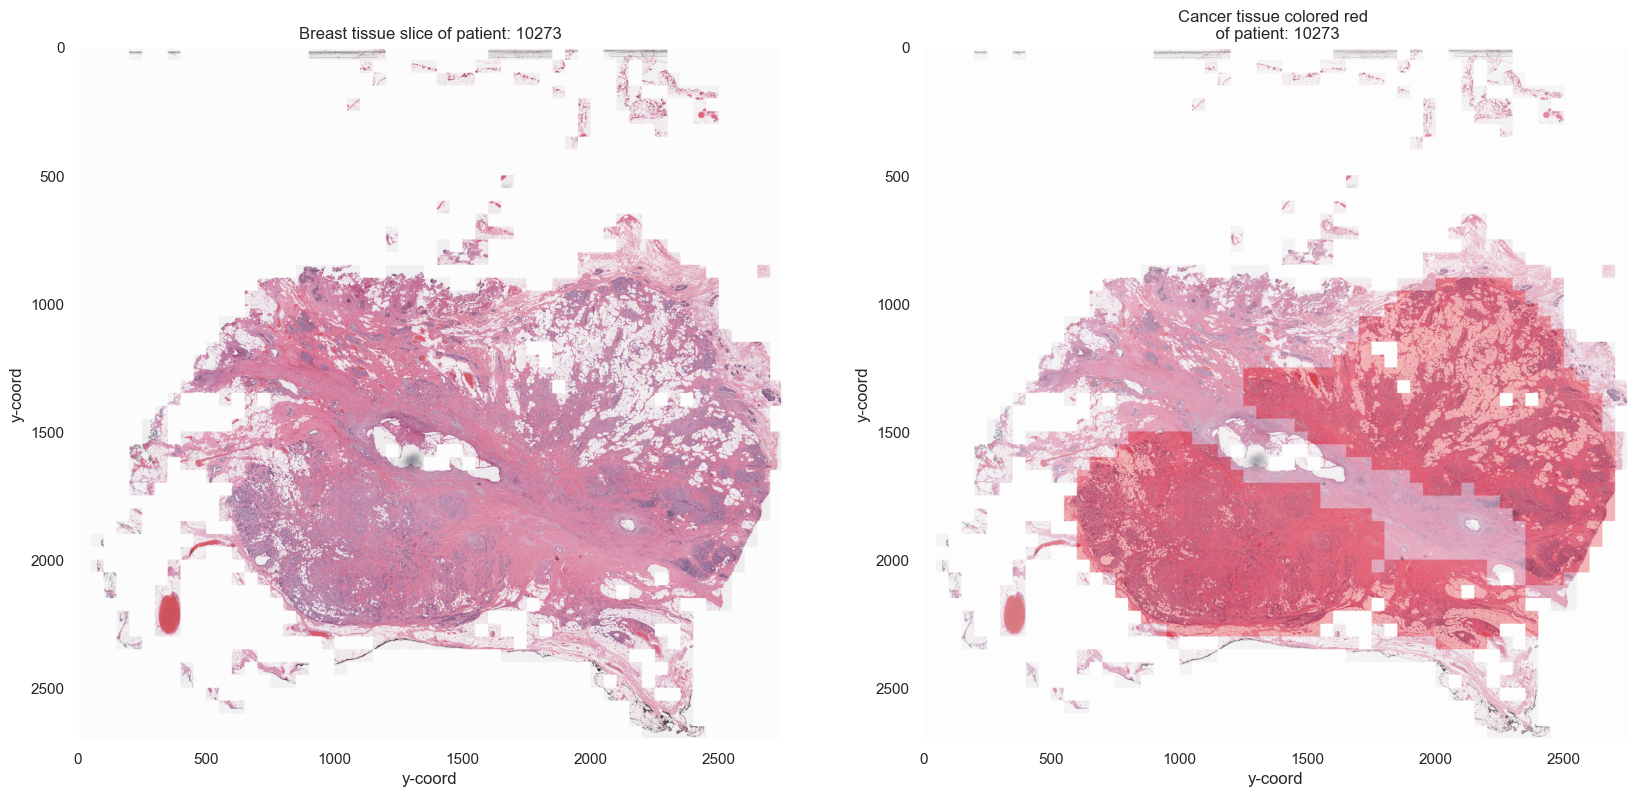

In [22]:
example = "13616"
grid, mask, broken_patches,_ = visualise_breast_tissue(example)

fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(grid, alpha=0.9)
ax[1].imshow(mask, alpha=0.8)
ax[1].imshow(grid, alpha=0.7)
ax[0].grid(False)
ax[1].grid(False)
for m in range(2):
    ax[m].set_xlabel("y-coord")
    ax[m].set_ylabel("y-coord")
ax[0].set_title("Breast tissue slice of patient: " + patient_id)
ax[1].set_title("Cancer tissue colored red \n of patient: " + patient_id);

title = 'Ricostruzione scan complessiva'
fig.savefig(os.path.join(output_dir, title+'.png'))
plt.show()

In [23]:
broken_patches

[]

## Machine Learning setup

In [24]:
torch.manual_seed(0)
np.random.seed(0)

In [25]:
data.head()
data.loc[:, "target"] = data.target.astype(str)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 277524 entries, 0 to 277523
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   patient_id  277524 non-null  object
 1   path        277524 non-null  object
 2   target      277524 non-null  object
dtypes: object(3)
memory usage: 13.5+ MB


In [26]:
patients = data.patient_id.unique()

train_ids, sub_test_ids = train_test_split(patients,
                                           test_size=0.3,
                                           random_state=0)
test_ids, dev_ids = train_test_split(sub_test_ids, test_size=0.5, random_state=0)

In [27]:
print(len(train_ids)/patients.shape[0]*100, len(dev_ids)/patients.shape[0]*100, len(test_ids)/patients.shape[0]*100)

69.89247311827957 15.053763440860216 15.053763440860216


In [28]:
print(len(train_ids), len(dev_ids), len(test_ids))

195 42 42


In [29]:
train_df = data.loc[data.patient_id.isin(train_ids),:].copy()
test_df = data.loc[data.patient_id.isin(test_ids),:].copy()
dev_df = data.loc[data.patient_id.isin(dev_ids),:].copy()

train_df = extract_coords(train_df)
test_df = extract_coords(test_df)
dev_df = extract_coords(dev_df)

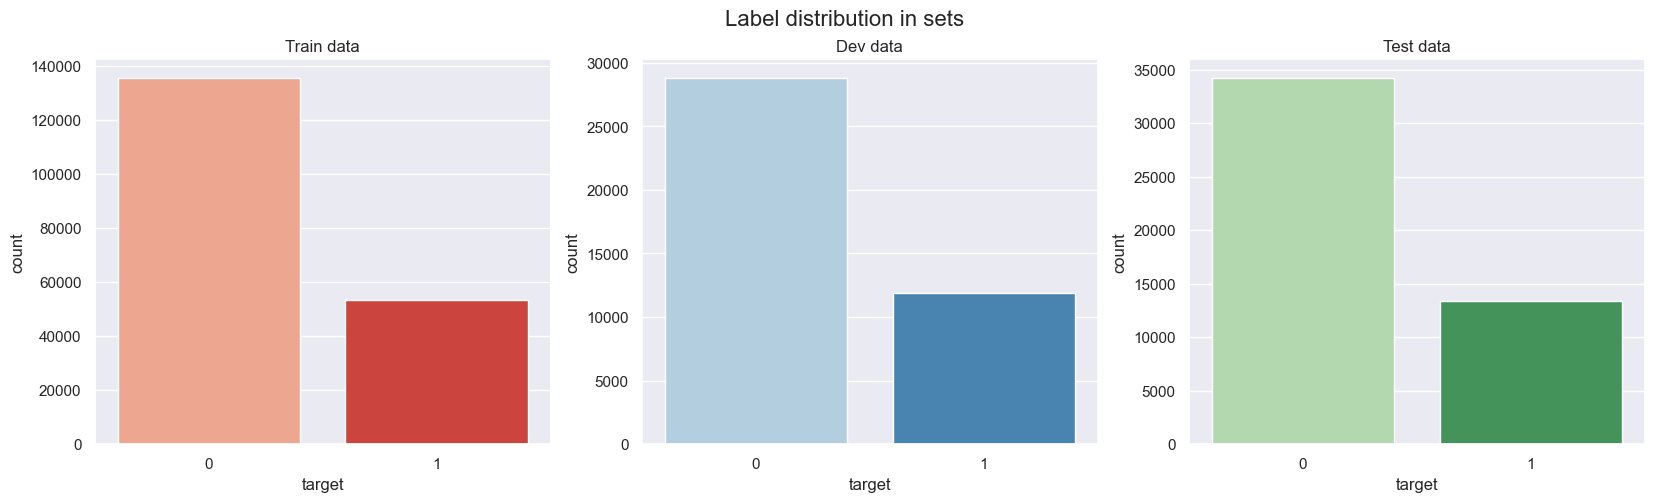

In [30]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
sns.countplot(train_df, x = "target", ax=ax[0], palette="Reds")
ax[0].set_title("Train data")
sns.countplot(dev_df, x = "target", ax=ax[1], palette="Blues")
ax[1].set_title("Dev data")
sns.countplot(test_df, x = "target", ax=ax[2], palette="Greens");
ax[2].set_title("Test data");

title = 'Label distribution in sets'
fig.suptitle(title, fontsize=16)
fig.savefig(os.path.join(output_dir, title+'.png'))
plt.show()

In [31]:
train_df.to_pickle(os.path.join(processed_data_dir, 'train_df.pkl'))
test_df.to_pickle(os.path.join(processed_data_dir, 'test_df.pkl'))
dev_df.to_pickle(os.path.join(processed_data_dir, 'train_df.pkl'))


In [32]:
train_df

patient_id                                               path target  \
0           10253  c:\Users\noemi\OneDrive\Documenti\GitHub\CNN-v...      0   
1           10253  c:\Users\noemi\OneDrive\Documenti\GitHub\CNN-v...      0   
2           10253  c:\Users\noemi\OneDrive\Documenti\GitHub\CNN-v...      0   
3           10253  c:\Users\noemi\OneDrive\Documenti\GitHub\CNN-v...      0   
4           10253  c:\Users\noemi\OneDrive\Documenti\GitHub\CNN-v...      0   
...           ...                                                ...    ...   
277519       9383  c:\Users\noemi\OneDrive\Documenti\GitHub\CNN-v...      1   
277520       9383  c:\Users\noemi\OneDrive\Documenti\GitHub\CNN-v...      1   
277521       9383  c:\Users\noemi\OneDrive\Documenti\GitHub\CNN-v...      1   
277522       9383  c:\Users\noemi\OneDrive\Documenti\GitHub\CNN-v...      1   
277523       9383  c:\Users\noemi\OneDrive\Documenti\GitHub\CNN-v...      1   

           x     y  
0       1001  1001  
1       1001  1051  
2       1001  1101  
3       1001  1151  
4       1001  1201  
...      ...   ...  
277519  2051   901  
277520  2051   951  
277521  2101  1001  
277522  2101   901  
277523  2101   951  

[189156 rows x 5 columns]